#Team member(s): Jasleen and Samah

In [ ]:
!pip install -U numpy==1.18.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade tensorflow==1.15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 27 kB/s 
     |████████████████████████████████| 3.8 MB 79.4 MB/s 
     |████████████████████████████████| 50 kB 7.5 MB/s 
     |████████████████████████████████| 503 kB 96.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=19b78b524b089bd94383757f823de7462f59f1dd8e8416f842c0b5343fe0347f
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting un

In [ ]:
!pip3 show tensorflow

Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: gast, tensorflow-estimator, wheel, numpy, keras-preprocessing, protobuf, tensorboard, six, wrapt, astor, grpcio, google-pasta, opt-einsum, termcolor, absl-py, keras-applications
Required-by: kapre


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from numpy.core.numeric import shape
from sklearn import metrics

#Team member(s): Jasleen

In [ ]:
# parts of the code come from:
#https://www.depends-on-the-definition.com/named-entity-recognition-with-residual-lstm-and-elmo/ ,
#https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/ ,
#https://tfhub.dev/google/elmo/3
#https://www.insofe.edu.in/insights/how-to-use-elmo-embedding-in-bidirectional-lstm-model-architecture/
  
#config parameter
max_len=128
epochs =5
batch_size =32

In [ ]:
#import and prepare the dataset
data = pd.read_csv('/ner_dataset.csv', encoding='latin1')
data.fillna(method = 'ffill',inplace = True)
#check and drop null values
data = data.dropna()
data.isnull().values.any() 
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
#creat a list of unique word and add paded element 
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words) 
#creat a list of unique tages and add paded element
tags = list(set(data["Tag"].values))
n_tags = len(tags)
# print(n_tags)
# print(n_words)

In [ ]:
# aggregate words and tages of each sentence 
agg_func = lambda s: [(w, p) for w, p in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
sentences_tags = data.groupby("Sentence #").apply(agg_func)
sentences = [s for s in sentences_tags]
#print(sentences[0])

In [ ]:
#store the words of each sentence in a list(X represents list of sentences and each sentence represent list of words)
X = [[w[0] for w in s] for s in sentences]
# assign each tage a numeric value
tag2idx = {t: i for i, t in enumerate(tags)}
# print(X[0])
# print(tag2idx)

In [ ]:
#pad each sentence to the max_len
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X = new_X

In [ ]:
#replace each tage with its numeric value
y = [[tag2idx[w[1]] for w in s] for s in sentences]
#pad the tages of each sentence to the max_len
y = pad_sequences(maxlen=max_len, sequences= y, padding="post", value=tag2idx['O'])
#convert tages to on_hot_vectors
y = [to_categorical(i,num_classes = n_tags) for i in y]
#print(y[0])

In [ ]:
#split the data into train, test, and validation
# train -> 75%, validation -> 15%, test -> 10% 
x_main, x_test, y_main, y_test  = train_test_split(X, y,
                                                            random_state=2020, test_size=0.1)
x_train, x_val, y_train, y_val  = train_test_split(x_main, y_main,
                                                            random_state=2020, test_size=0.15)

In [ ]:
# print(np.shape(x_train))
# print(np.shape(y_train))
# print(np.shape(x_test))
# print(np.shape(y_test))
# print(np.shape(x_val))
# print(np.shape(y_val))

In [ ]:
# initalize tensorflow session
sess = tf.Session()
keras.backend.set_session(sess)

In [ ]:
#load elmo model from tensorflow
elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
# Elmo function that can be used to represent word imbedding in our neural network
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)), #tokenes of each sentences
                            "sequence_len": tf.constant(batch_size*[max_len]) # the length of tokens for each sentence
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [ ]:
# check the output of Elmo function
elmo_example = elmo_model(['Elon Musk now owns Twitter'],
    signature="default",
    as_dict=True)["elmo"]

In [ ]:
# print the shape of input and the embedding of the second word in the sentence
print('Elmo output shape------>', elmo_example) 
print('The embeding of Musk------>' , sess.run(elmo_example[0][1]))

Elmo output shape------> Tensor("module_apply_default/aggregation/mul_3:0", shape=(1, 5, 1024), dtype=float32)
The embeding of Musk------> [-0.44626933 -0.03228204 -0.00986907 ... -0.03574952 -0.39661378
  0.01809607]


#Team member(s): Samah

In [ ]:
# Elmo requires all the batches to have the same length so we split the data based on that
split_tr = (np.shape(x_train)[0]//batch_size)*batch_size
split_val = (np.shape(x_val)[0]//batch_size)*batch_size
split_te = (np.shape(x_test)[0]//batch_size)*batch_size

In [ ]:
# neural network model using keras layers from tensorflow
# the model takes words of each sentence as input, find its word embedding using Elmo, 
#pass it through bidirectional LSTM, and return the predicted tages for each word using sofmax activiation function.
input = tf.keras.layers.Input(shape=(max_len,), dtype=tf.string)
embedding = tf.keras.layers.Lambda(ElmoEmbedding, output_shape=(None, 1024))(input)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation='relu', name='dense'))(x)
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_tags, activation="softmax"))(x)

#final model
model = tf.keras.Model(inputs = [input], outputs = [output])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
lambda (Lambda)              (32, None, 1024)          0         
_________________________________________________________________
bidirectional (Bidirectional (32, None, 1024)          6295552   
_________________________________________________________________
time_distributed (TimeDistri (None, None, 128)         131200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 17)          2193      
Total params: 6,428,945
Trainable params: 6,428,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#initializing optimizer, lost function, and mertics
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Training the model 
history = model.fit(np.array(x_train[:split_tr]), np.array(y_train[:split_tr]), epochs=epochs, batch_size = batch_size, validation_data=(np.array(x_val[:split_val]),np.array(y_val[:split_val])))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 36672 samples, validate on 6464 samples
Epoch 1/5
36672/36672 [==============================] - 5199s 142ms/sample - loss: 0.0271 - acc: 0.9921 - val_loss: 0.0172 - val_acc: 0.9945
Epoch 2/5
36672/36672 [==============================] - 5221s 142ms/sample - loss: 0.0160 - acc: 0.9948 - val_loss: 0.0163 - val_acc: 0.9948
Epoch 3/5
36672/36672 [==============================] - 4985s 136ms/sample - loss: 0.0136 - acc: 0.9954 - val_loss: 0.0163 - val_acc: 0.9948
Epoch 4/5
36672/36672 [==============================] - 5009s 137ms/sample - loss: 0.0115 - acc: 0.9960 - val_loss: 0.0158 - val_acc: 0.9949
Epoch 5/5
36672/36672 [==============================] - 5031s 137ms/sample - loss: 0.0097 - acc: 0.9965 - val_loss: 0.0166 - val_acc: 0.9948


In [ ]:
hist = pd.DataFrame(history.history)

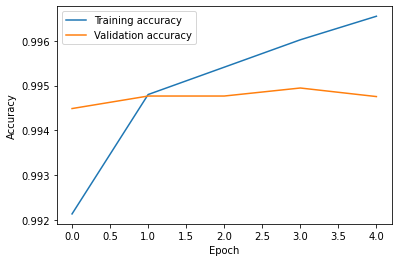

In [ ]:
plt.plot(range(5), hist["acc"], label = "Training accuracy")
plt.plot(range(5), hist["val_acc"], label = "Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

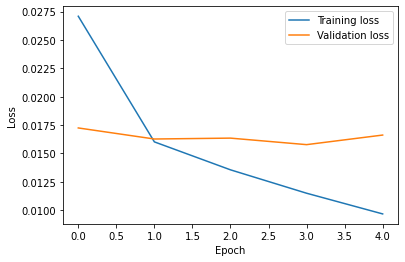

In [ ]:
plt.plot(range(epochs), hist["loss"], label = "Training loss")
plt.plot(range(epochs), hist["val_loss"], label = "Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Evaluate the model on testing dataset
model.evaluate([x_test[:split_te]], [y_test[:split_te]], batch_size=batch_size)

4768/4768 [==============================] - 410s 86ms/sample - loss: 0.0167 - acc: 0.9948


[0.016707165404254157, 0.99475014]

In [ ]:
#evaluate the model prediction  
y_predict = model.predict([x_test[:split_te]], batch_size=batch_size)
b=y_predict.argmax(axis =-1)
a = np.array(y_test[:split_te]).argmax(axis=-1)

In [ ]:
#print calssification report
print(metrics.classification_report(a.flatten(), b.flatten()))

              precision    recall  f1-score   support

           0       0.22      0.18      0.20        28
           1       0.81      0.88      0.84      1689
           2       0.96      0.94      0.95      1617
           3       0.78      0.79      0.78      1688
           4       0.82      0.73      0.77       669
           5       0.43      0.29      0.35        34
           6       0.87      0.89      0.88      1982
           7       0.87      0.88      0.87      3669
           8       0.11      0.07      0.09        28
           9       0.80      0.78      0.79       679
          10       0.86      0.89      0.88      1705
          11       0.58      0.41      0.48        17
          12       0.76      0.75      0.75      2023
          13       0.10      0.13      0.11        23
          14       0.40      0.29      0.33         7
          15       1.00      0.43      0.60        21
          16       1.00      1.00      1.00    594425

    accuracy              

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix(a.flatten(), b.flatten())
cm

array([[[610258,     18],
        [    23,      5]],

       [[608264,    351],
        [   198,   1491]],

       [[608617,     70],
        [   105,   1512]],

       [[608244,    372],
        [   358,   1330]],

       [[609525,    110],
        [   181,    488]],

       [[610257,     13],
        [    24,     10]],

       [[608061,    261],
        [   209,   1773]],

       [[606148,    487],
        [   439,   3230]],

       [[610260,     16],
        [    26,      2]],

       [[609493,    132],
        [   149,    530]],

       [[608352,    247],
        [   184,   1521]],

       [[610282,      5],
        [    10,      7]],

       [[607803,    478],
        [   510,   1513]],

       [[610254,     27],
        [    20,      3]],

       [[610294,      3],
        [     5,      2]],

       [[610283,      0],
        [    12,      9]],

       [[ 15265,    614],
        [   751, 593674]]])